# 豆瓣电影TOP100分析  

## 载入所需库

In [1]:
import requests
import pandas as pd
import numpy as np
from time import sleep

## 从豆瓣API上下载数据

In [3]:
url = 'http://api.douban.com/v2/movie/top250'
movie_data = []

for start in range(0, 100, 25):
    response = requests.get(url, params={'start': start,'count': 25})
    r_json = response.json()
    for movie in r_json['subjects']:
        movie_data.append(movie)
    sleep(1)  #因为豆瓣有响应限制，所以要暂停片刻
    
movie_df = pd.DataFrame(movie_data)

## 提取分析特征

In [148]:
#复制数据，保留原数据
df = movie_df.copy()

#删除不想分析的特征
df.drop(['alt','images', 'original_title', 'subtype'], axis=1, inplace=True)

#从director中仅提取name
def ex_directors(dire):
    names = []
    for i in dire:
        names.append(i['name'])
    return names
df.directors = df.directors.apply(ex_directors)

#从cast中仅提取name
def ex_casts(cas):
    names = []
    for i in cas:
        names.append(i['name'])
    return names
df.casts = df.casts.apply(ex_casts)

#从rating中仅提取average
def avg_rating(rating):
    return rating['average']
df.rating = df.rating.apply(avg_rating)

检查数据

In [150]:
df.head(10)

,casts,collect_count,directors,genres,id,rating,title,year
0,"[蒂姆·罗宾斯, 摩根·弗里曼, 鲍勃·冈顿]",1304404,[弗兰克·德拉邦特],"[犯罪, 剧情]",1292052,9.6,肖申克的救赎,1994
1,"[张国荣, 张丰毅, 巩俐]",942235,[陈凯歌],"[剧情, 爱情, 同性]",1291546,9.5,霸王别姬,1993
2,"[让·雷诺, 娜塔莉·波特曼, 加里·奥德曼]",1234055,[吕克·贝松],"[剧情, 动作, 犯罪]",1295644,9.4,这个杀手不太冷,1994
3,"[汤姆·汉克斯, 罗宾·怀特, 加里·西尼斯]",1086523,[罗伯特·泽米吉斯],"[剧情, 爱情]",1292720,9.4,阿甘正传,1994
4,"[罗伯托·贝尼尼, 尼可莱塔·布拉斯基, 乔治·坎塔里尼]",609057,[罗伯托·贝尼尼],"[剧情, 喜剧, 爱情]",1292063,9.5,美丽人生,1997
5,"[柊瑠美, 入野自由, 夏木真理]",985943,[宫崎骏],"[剧情, 动画, 奇幻]",1291561,9.3,千与千寻,2001
6,"[莱昂纳多·迪卡普里奥, 凯特·温丝莱特, 比利·赞恩]",1005653,[詹姆斯·卡梅隆],"[剧情, 爱情, 灾难]",1292722,9.3,泰坦尼克号,1997
7,"[连姆·尼森, 本·金斯利, 拉尔夫·费因斯]",571575,[史蒂文·斯皮尔伯格],"[剧情, 历史, 战争]",1295124,9.4,辛德勒的名单,1993
8,"[莱昂纳多·迪卡普里奥, 约瑟夫·高登-莱维特, 艾伦·佩吉]",1075463,[克里斯托弗·诺兰],"[剧情, 科幻, 悬疑]",3541415,9.3,盗梦空间,2010
9,"[本·贝尔特, 艾丽莎·奈特, 杰夫·格尔林]",697356,[安德鲁·斯坦顿],"[爱情, 科幻, 动画]",2131459,9.3,机器人总动员,2008


发现豆瓣TOP250并不包含电影的country，所以只能根据电影的id来逐条提取country。

In [112]:
#生成各部电影的url，由统一url和电影的唯一id组成
url = 'http://api.douban.com/v2/movie/subject/'
movie_countries = []
movie_ids = df.id

for movie_id in movie_ids:
    resp = requests.get(url+movie_id)
    r_js = resp.json()
    try:
        id_item = {'id': movie_id, 'country_or_area': r_js['countries']}
    except KeyError:
        id_item = {'id': movie_id, 'country_or_area': np.nan}  #电影有时会下载不到country信息，所以要有异常处理
    movie_countries.append(id_item)
    sleep(1)  #同样有响应限制，那么就暂停一下
    
countries = pd.DataFrame(movie_countries)

查看数据

In [151]:
countries.sample(5)

,country_or_area,id
61,[伊朗],1303021
45,[美国],3442220
22,[香港],1307914
26,[美国],1293182
43,[日本],1308807


将两张表格结合，补充country信息。

In [152]:
df = pd.merge(df, countries, on='id', how='inner')

查看数据

In [169]:
df.sample(5)

,casts,collect_count,directors,genres,id,rating,title,year,country_or_area
41,"[杰克·尼科尔森, 丹尼·德维托, 克里斯托弗·洛伊德]",399006,[米洛斯·福尔曼],[剧情],1292224,9.0,飞越疯人院,1975,[美国]
18,"[马修·麦康纳, 安妮·海瑟薇, 杰西卡·查斯坦]",647248,[克里斯托弗·诺兰],"[剧情, 科幻, 冒险]",1889243,9.2,星际穿越,2014,"[美国, 英国, 加拿大, 冰岛]"
28,"[爱德华·诺顿, 布拉德·皮特, 海伦娜·伯翰·卡特]",554916,[大卫·芬奇],"[剧情, 动作, 悬疑]",1292000,9.0,搏击俱乐部,1999,NaN
10,"[阿米尔·汗, 卡琳娜·卡普尔, 马达范]",957992,[拉吉库马尔·希拉尼],"[剧情, 喜剧, 爱情]",3793023,9.2,三傻大闹宝莱坞,2009,[印度]
96,"[吴念真, 李凯莉, 金燕玲]",216561,[杨德昌],"[剧情, 爱情, 家庭]",1292434,8.9,一一,2000,"[台湾, 日本]"


查看是否有country没有提取到的条目

In [197]:
df[df.country_or_area.isna()]

,casts,collect_count,directors,genres,id,rating,title,year,country_or_area


果然有，查看可知电影的index，那么就在豆瓣上查找，手动补充信息。

In [187]:
#注意要用.at[]而不是.loc[]!
#注意编码格式是unicode！
df.at[19, 'country_or_area'] = [u'\u97e9\u56fd']
df.at[28, 'country_or_area'] = [u'\u7f8e\u56fd',u'\u5fb7\u56fd']

## 可视化分析  

OK，数据都下载好了，下面就进行可视化分析。  

首先，加载绘图用的库，并设置绘图格式。

In [217]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.family'] = 'SimHei' #配置中文字体
matplotlib.rcParams['font.size'] = 15   # 更改默认字体大小  

首先查看哪个国家或者地区产出的高质量电影最多。

In [216]:
area = df.country_or_area.apply(pd.value_counts).fillna(0)
area = area.apply(np.sum).astype(int)

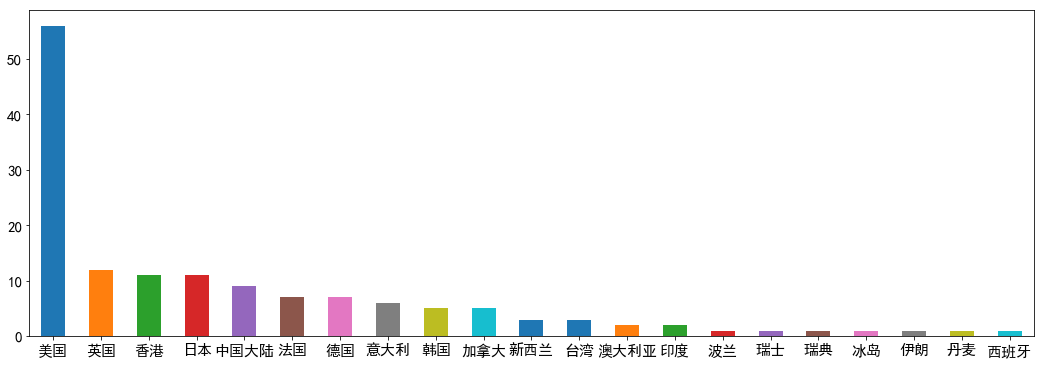

In [231]:
area.sort_values(ascending=False).plot(kind = 'bar', figsize=(18,6), rot=0)

厉害了美国...  

接下来查看高分电影基本都属于什么类型。

In [220]:
genre = df.genres.apply(pd.value_counts).fillna(0)
genre = genre.apply(np.sum).astype(int)

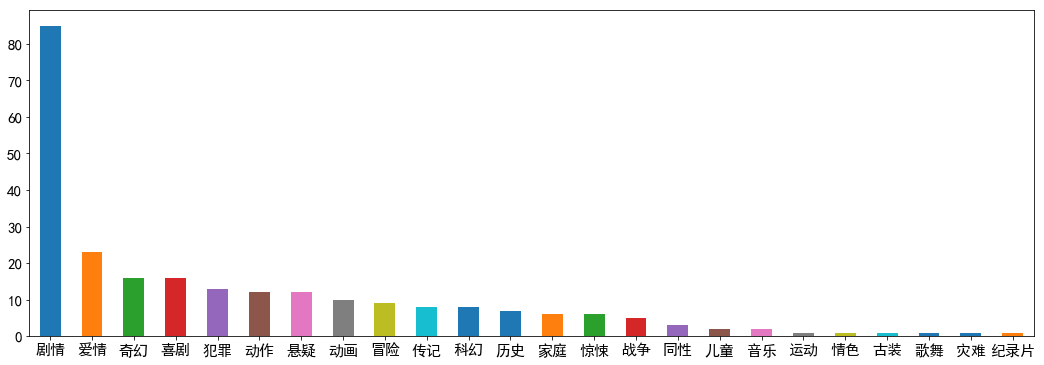

In [232]:
genre.sort_values(ascending=False).plot('bar', figsize=(18,6), rot=0)

其实我一直都不太懂所谓的“剧情片”是个什么定义，好吧...这不重要...  

接下来查看最佳贡献奖要颁给哪位导演。

In [239]:
director = df.directors.apply(pd.value_counts).fillna(0)
director = director.apply(np.sum).astype(int)
director_top20 = director.sort_values(ascending = False).head(20)

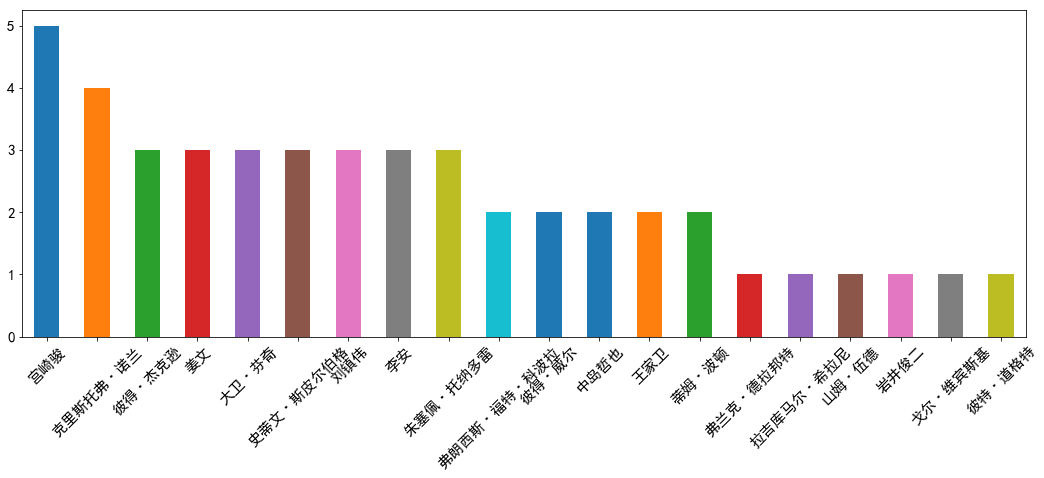

In [245]:
director_top20.plot('bar', figsize=(18,6), rot=45)

我真的没有想到是宫崎骏！！！  
而且姜文和王家卫简直撑起来国产电影的半壁江山啊！  

好...接下来查看最佳贡献奖还可以颁给哪位演员。

In [246]:
cast = df.casts.apply(pd.value_counts).fillna(0)
cast = cast.apply(np.sum).astype(int)
cast_top20 = cast.sort_values(ascending = False).head(20)

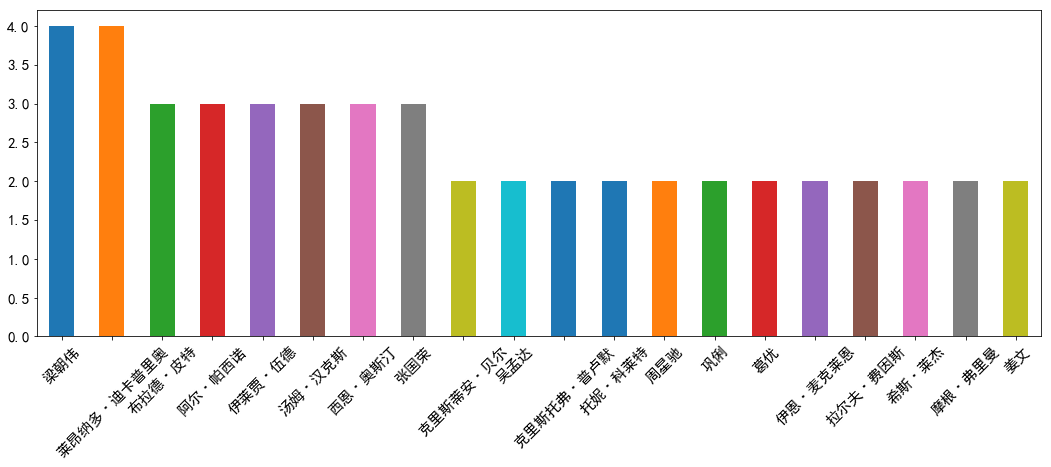

In [247]:
cast_top20.plot('bar', figsize=(18,6), rot=45)

其实网上分析的TOP250中，最多影片数的是张国荣，哥哥...  

下面查看年份和排名是否有关系。

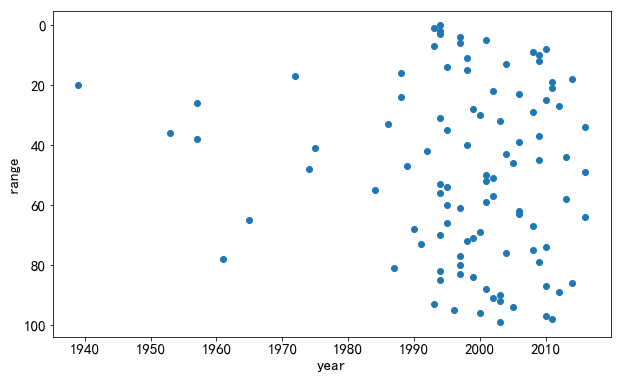

In [265]:
plt.figure(figsize=(10,6))
plt.scatter(df.year, df.index)  #index就是排名
plt.ylabel('range')
plt.xlabel('year')
plt.gca().invert_yaxis()  #排名数越小，说明越高，所以要倒过来

起码从这张图来看，关系不大。  

接下来查看排名和点评人数是否有关。

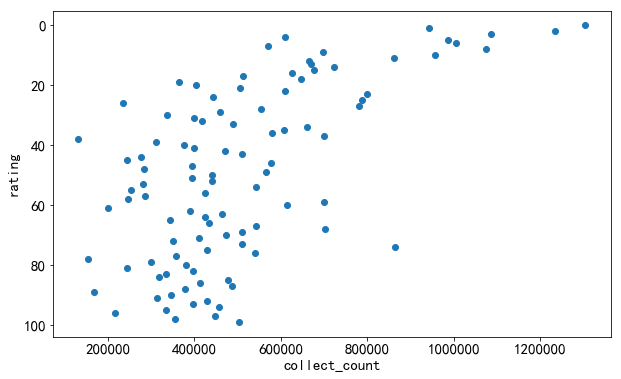

In [261]:
plt.figure(figsize=(10,6))
plt.scatter(df.collect_count, df.index)
plt.gca().invert_yaxis()
plt.ylabel('rage')
plt.xlabel('collect_count')

从这张图来看，关系还是挺密切的，即点评人数越多，就有可能拉高排名。  
其实本来想用皮尔逊系数，但是index貌似不能被计算，看来还是应该单独提取出排名特征。